In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})
import seaborn as sns

%load_ext autoreload
%autoreload 2
package_path = r'E:\TMC\PRISM_Code\gene_calling'
if package_path not in sys.path: sys.path.append(package_path)


BASE_DIR = Path(r'F:\spatial_data\processed')
RUN_ID = '20240902_PRISM_64_Mouse_Brain_adjust_1'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
figure_dir = read_dir / 'figures'
os.makedirs(read_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

## plt images

### demo and trial for one

In [ ]:
mapped_genes = pd.read_csv(read_dir / 'mapped_genes.csv')
gene_list = mapped_genes['gene'].unique()

In [ ]:
downsample_factor = 100

projection_yrange = mapped_genes['Y'].min() - 2000, mapped_genes['Y'].max() + 2000 
projection_xrange = mapped_genes['X'].min() - 2000, mapped_genes['X'].max() + 2000
bins = ((projection_xrange[1] - projection_xrange[0]) // downsample_factor, 
        (projection_yrange[1] - projection_yrange[0]) // downsample_factor)

In [ ]:
main_plot_width_inch = bins[0] / bins[1] * 10
cbar_width_inch = 0.2  # 你希望的颜色条宽度（单位：英寸）
fig_width_inch = main_plot_width_inch + cbar_width_inch + 1
fig_height_inch = 10

# 计算主图的尺寸，预留颜色条的空间
left_space_inch = (fig_width_inch - main_plot_width_inch) / 2

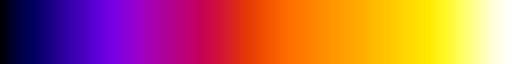

In [ ]:
from cmap import Colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Load the 'fire' colormap using the custom Colormap class
cmap_fire_custom = Colormap('imagej:fire')

# Extract the colors from the custom colormap
percentile = 100
colors = [c for c in cmap_fire_custom.iter_colors()]
colors = [colors[_] for _ in range(len(colors) * percentile // 100)]

# Interpolate colors to create a smoother colormap
def interpolate_colors(colors, num_colors):
    """
    Interpolate a list of colors to create a smoother gradient.
    
    :param colors: List of color tuples.
    :param num_colors: Number of colors in the new colormap.
    :return: List of interpolated color tuples.
    """
    original_indices = np.linspace(0, 1, len(colors))
    new_indices = np.linspace(0, 1, num_colors)
    interpolated_colors = []

    for i in range(3):  # For R, G, B channels
        channel = np.array([c[i] for c in colors])
        interpolated_channel = np.interp(new_indices, original_indices, channel)
        interpolated_colors.append(interpolated_channel)

    return list(zip(interpolated_colors[0], interpolated_colors[1], interpolated_colors[2]))

# Interpolate to create a colormap with 256 colors
num_colors = 256
smooth_colors = interpolate_colors(colors, num_colors)

# Create a new ListedColormap
cmap_fire = ListedColormap(smooth_colors)
cmap_fire

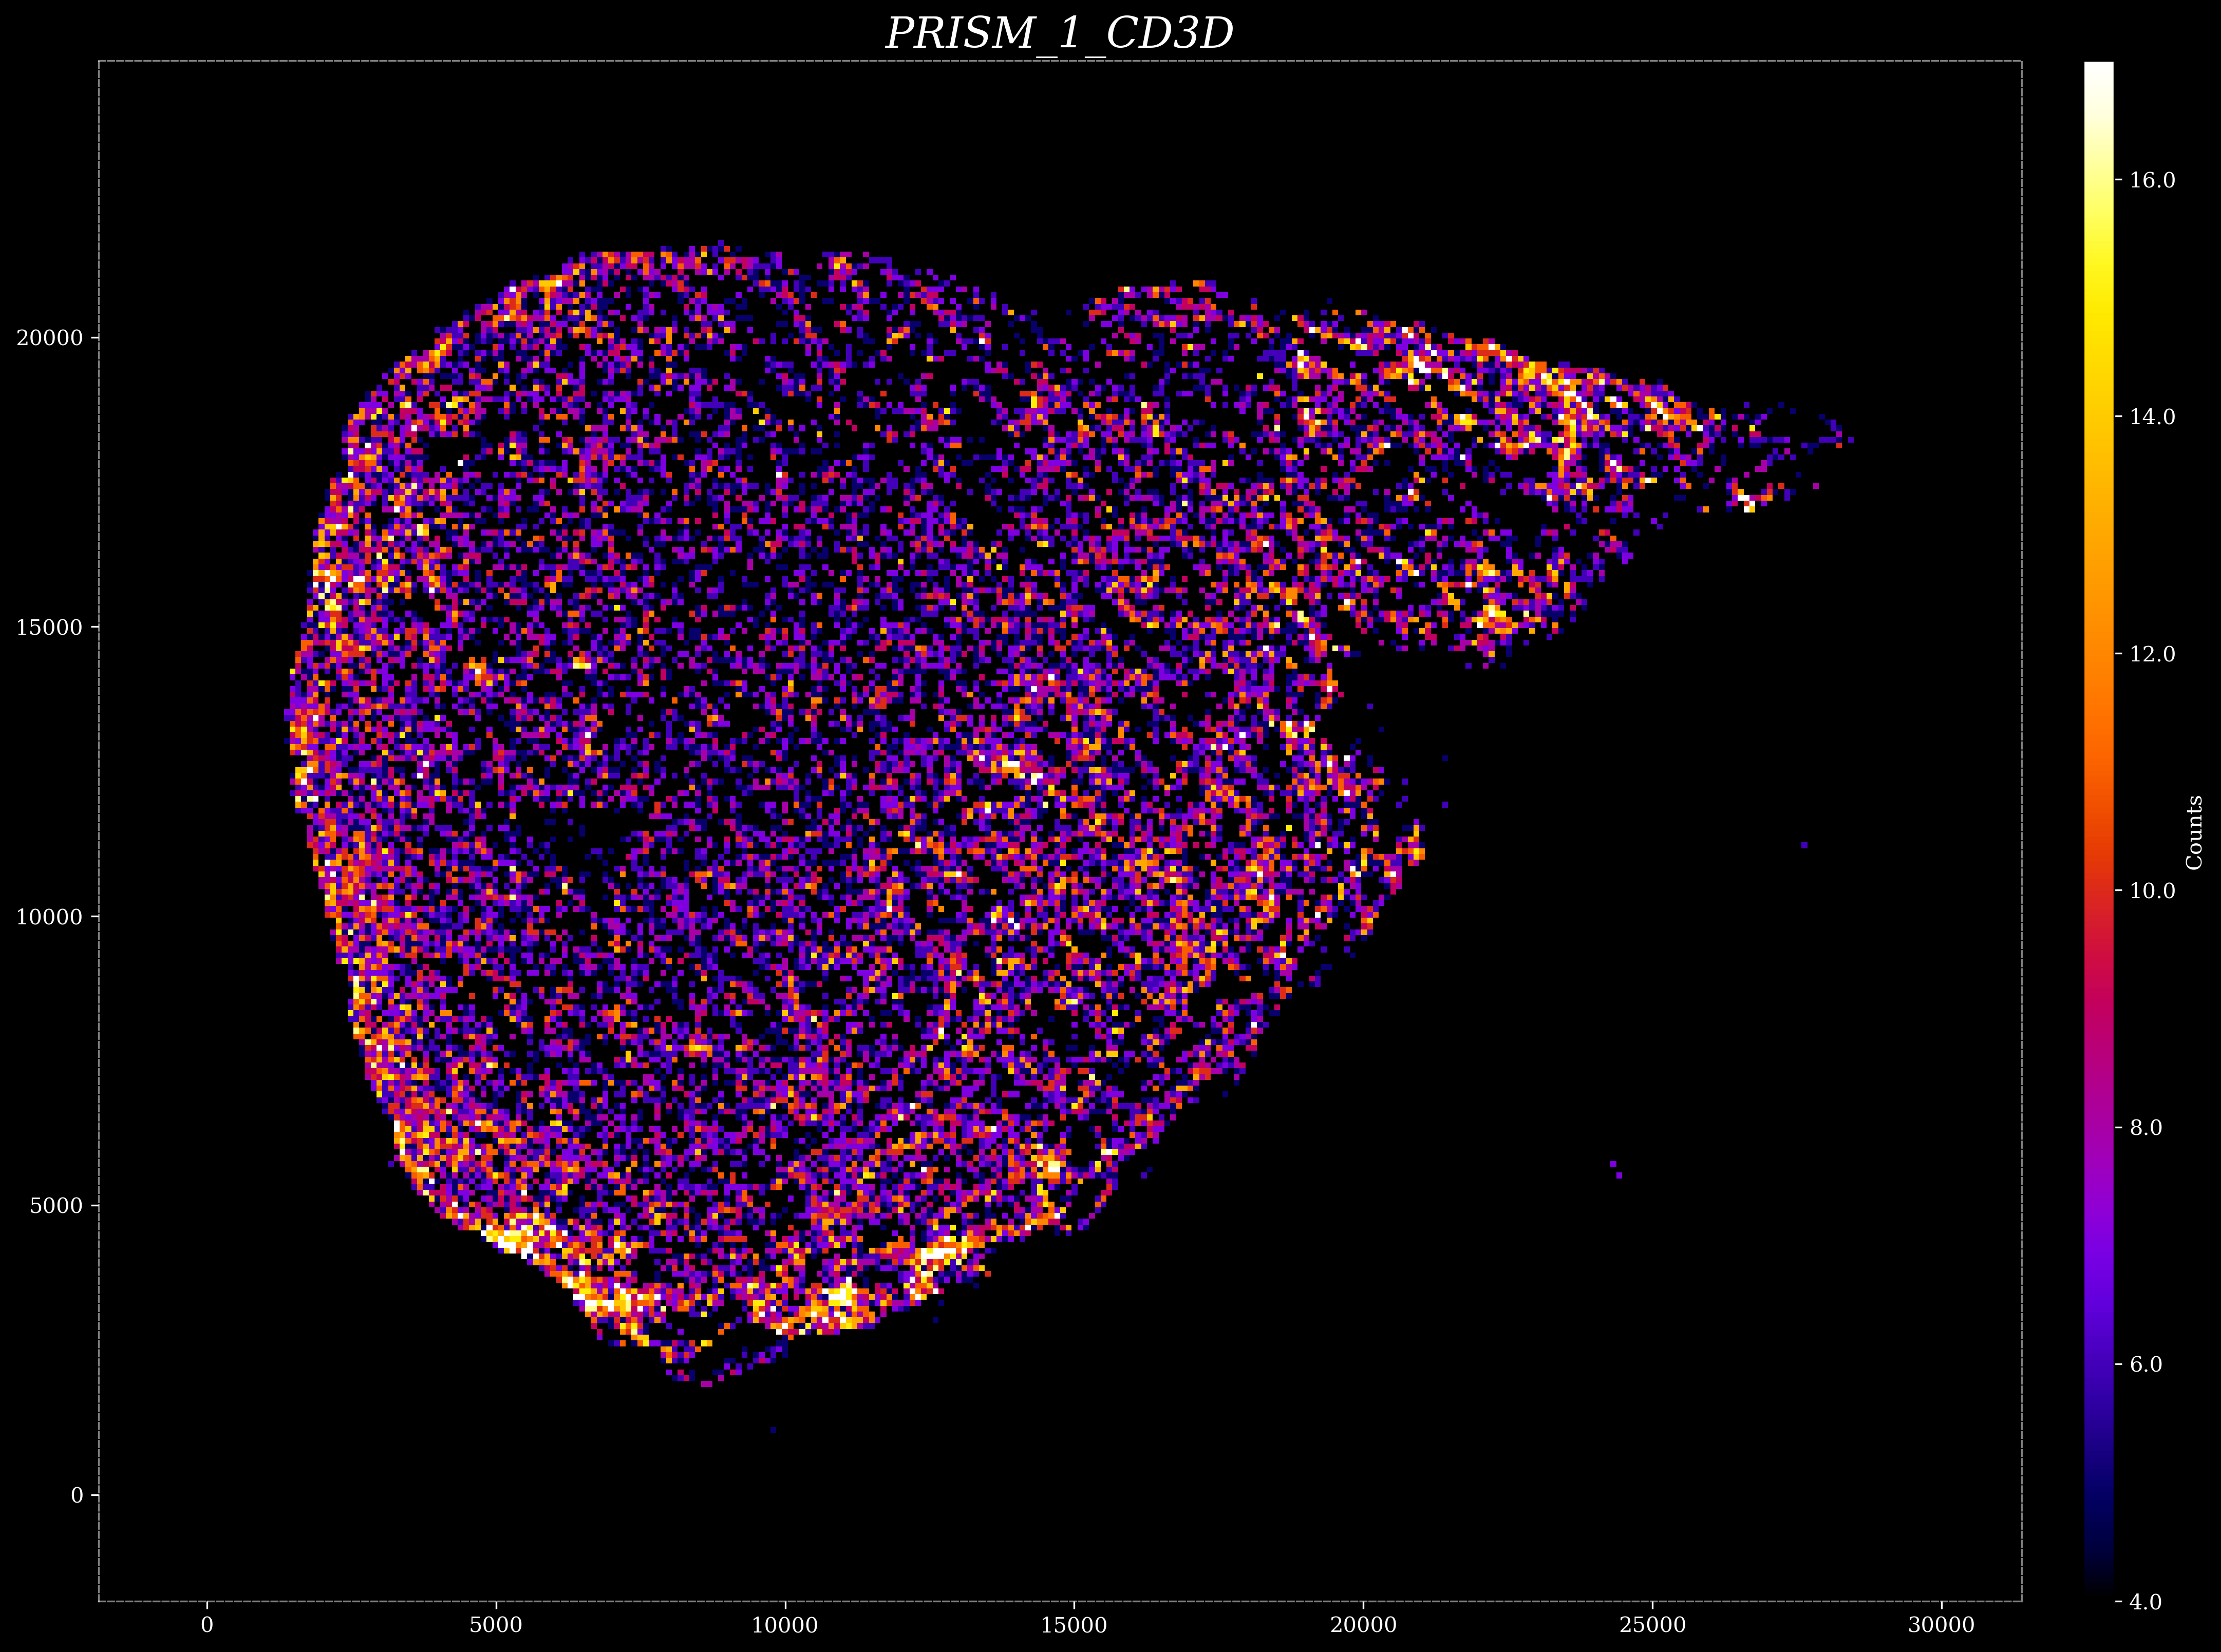

In [ ]:
from turtle import position
import matplotlib

gene_order=1
gene_name = gene_list[gene_order-1]
points = mapped_genes[mapped_genes['Gene']==gene_name][['X', 'Y']].values
# points = intensity15[intensity15['snr']>2][['X', 'Y']].values

x = points[:, 0]
y = points[:, 1]

def projection_gene(x, y, bins=bins, outpath=None):
    # Creating the 2D histogram
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    percentile_max = np.percentile(hist, 99.98)
    percentile_min = min(max(1, np.percentile(hist, 90)), percentile_max // 4)
    # percentile_min = percentile_max / 3
    # percentile_min = 1

    fig = plt.figure(figsize=(fig_width_inch, fig_height_inch))
    ax = fig.add_axes([left_space_inch/fig_width_inch, 0, main_plot_width_inch/fig_width_inch, 1])
    fig.patch.set_facecolor('black')
    plt.hist2d(x, y, 
                range=[projection_xrange, projection_yrange],
                bins=bins, 
                vmax=percentile_max,
                vmin=percentile_min,
                cmap=cmap_fire,
                )
    
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')

    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linestyle('--')
        spine.set_alpha(0.5)

    ax.tick_params(colors='white', which='both')  # 'both' means both major and minor ticks are affected

    cax = fig.add_axes([1 - cbar_width_inch/fig_width_inch, 0, cbar_width_inch/fig_width_inch, 1])  # 注意这里的坐标系是[左, 下, 宽, 高]
    cbar = plt.colorbar(cax=cax)
    # cbar = plt.colorbar(fraction=0.02)
    cbar.set_label('Counts', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.ax.yaxis.set_tick_params(labelcolor='white')
    cbar.formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{round(x,1)}')
    cbar.update_ticks()
    
    ax.set_title(f'{gene_name.upper()}', fontsize=20, fontstyle='italic')
    plt.tight_layout()
    if outpath is None: plt.show()
    else: plt.savefig(os.path.join(outpath, f'{gene_name}.png'), dpi=300, bbox_inches='tight')
    plt.close()
        
projection_gene(x=x, y=y, bins=bins)

### batch export 

#### use 2d hist and export to png files

In [ ]:
out_path = read_dir / 'density'
os.makedirs(out_path, exist_ok=True)

for gene_order in tqdm(range(1, len(gene_list)+1)):
  gene_name = gene_list[gene_order-1]
  points = mapped_genes[mapped_genes['Gene']==gene_name][['X', 'Y']].values

  # Extracting x and y coordinates
  x = points[:, 0]
  y = points[:, 1]

  projection_gene(x, y, outpath=out_path)

100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


# tiff images

In [ ]:
from glob import glob
from tifffile import TiffFile, imwrite

density_dir = read_dir / 'density_tiff'
# read imshape using tifffile without loading the whole image
im_shape = TiffFile(stc_dir/'cyc_1_cy3.tif').pages[0].shape

def plot_density_downsample(df, filename, fac=100):
    y = (im_shape[0] // fac) + 1
    x = (im_shape[1] // fac) + 1
    coordinates = df[['Y','X']].to_numpy()
    canvas = np.zeros((y*fac,x*fac),dtype=np.uint16)
    canvas[coordinates[:,0],coordinates[:,1]] = 1
    canvas_down = canvas.reshape(y,fac,x,fac).sum(-1).sum(1)
    imwrite(filename,canvas_down.astype(np.uint16))

In [ ]:
mapped_genes = pd.read_csv(read_dir / 'mapped_genes.csv')
gene_list = mapped_genes['gene'].unique()

for gene in tqdm(gene_list):
    if glob(str(density_dir / f'{gene}.tif')): continue
    else: plot_density_downsample(mapped_genes[mapped_genes['Gene']==gene], density_dir/f'{gene}.tif')